# PA005: High Value Customer Identification

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

## Assumptions

1. Produtos com valores igual a 0, trataremos como brindes e foram retiradas do dataset
2. Stock_codes que indicam valores menos que 0 ou sem descrição de produto, foram removidos, devido ao não entendimento da regra de negócio
3. Registros sem customer_id serão utilizados, porém, foram criados valores aleatórias para captar o comportamento dos clientes


# 0.0. Imports

In [105]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import warnings
import datetime as dt
import pandas_profiling
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import ensemble as en
from sklearn.manifold import TSNE

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 25
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    warnings.filterwarnings('ignore')
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
!cd

C:\Users\rauul\repos\insiders_clustering\notebooks


In [4]:
# load data
df_raw = pd.read_csv( r'..\data\raw\Ecommerce.csv', encoding= 'unicode_escape')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='black'> 1.0. Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
             'unit_price', 'customer_id', 'country']

In [7]:
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

Attributes Desciption

* invoice_no   -> número referente a transação do cliente, valor único para cada transação

* stock_code   -> código do item

* description  -> descrição do item

* quatity      -> quantidade de cada item por transação

* invoice_date -> data que a transação foi gerada

* unit_price   -> preço unitário do produto

* customer_id  -> ID do ciente

* country      -> localizaão do cliente 

In [9]:
df1.head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0000,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,29-Nov-16,2.7500,17850.0000,United Kingdom


In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isnull().sum()

invoice_no           0
stock_code        6035
description       7489
quantity          6035
invoice_date      6035
unit_price        6035
customer_id     138727
country           6035
dtype: int64

## 1.5. Replace NA

In [12]:
df1 = df1[~df1['stock_code'].isna()]

In [13]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     132692
country              0
dtype: int64

In [14]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [15]:
# check customer id, if invoice_no in missing dataset into invoices not missing dataset
missing_invoice = df_missing['invoice_no'].drop_duplicates().to_list()
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice),'customer_id']

Series([], Name: customer_id, dtype: float64)

In [16]:
# create refence to use missing values
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000,19000+len(df_backup),1)

# merge original with reference datafram
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

df1.head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,29-Nov-16,2.5500,United Kingdom,17850.0000
1,536365,71053,WHITE METAL LANTERN,6.0000,29-Nov-16,3.3900,United Kingdom,17850.0000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,29-Nov-16,2.7500,United Kingdom,17850.0000


In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [18]:
# remove na
#df1 = df1.dropna(subset=['description','customer_id'])
#print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

In [19]:
df_missing.tail(30)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
541511,581498,71053,WHITE MOROCCAN METAL LANTERN,1.0000,7-Dec-17,8.2900,NaN,United Kingdom
541512,581498,72349b,SET/6 PURPLE BUTTERFLY T-LIGHTS,2.0000,7-Dec-17,4.1300,NaN,United Kingdom
541513,581498,79321,CHILLI LIGHTS,10.0000,7-Dec-17,12.4600,NaN,United Kingdom
541514,581498,82001s,SILVER RECORD COVER FRAME,2.0000,7-Dec-17,7.4600,NaN,United Kingdom
541515,581498,82482,WOODEN PICTURE FRAME WHITE FINISH,4.0000,7-Dec-17,4.9600,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5.0000,7-Dec-17,4.1300,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4.0000,7-Dec-17,4.1300,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1.0000,7-Dec-17,4.9600,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1.0000,7-Dec-17,10.7900,NaN,United Kingdom


## 1.6. Change dtypes

In [20]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [21]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y') #format é o formato origiral que está no dataset, para sim a função realizar a formatação

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [22]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2016-11-29,2.5500,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6.0000,2016-11-29,3.3900,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2016-11-29,2.7500,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2016-11-29,3.3900,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2016-11-29,3.3900,United Kingdom,17850


## 1.7. Descriptive Statistics

In [23]:
num_att = df1.select_dtypes(include=['float64','int64'])
cat_att = df1.select_dtypes(exclude=['float64','int64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [24]:
# central tedency
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.mean)).T

# dispersion metrics
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(np.min)).T
d3 = pd.DataFrame(num_att.apply(np.max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-74215.0000,74215.0000,148430.0000,9.5879,9.5879,153.2921,-0.4889,205255.5138
1,unit_price,-11062.0600,38970.0000,50032.0600,4.6365,4.6365,97.3021,185.4702,58350.6559
2,customer_id,12346.0000,22696.0000,10350.0000,16679.6937,16679.6937,2907.3356,0.4905,-0.7984


### 1.7.1.1. Numerical Attributes - Investigating

**Parâmetros para verificar**

1. Quantity:
    - Quantidades negativas e quantidade muito altas, fugindo da média e mediana dos dados
        - Podendo ser devoluções ou correções de estoque


2. Unit_price:
    - valores zerados, podendo indicar descontos ou devoluções

### 1.7.2. Categorical Attributes

In [25]:
cat_att.head(3)

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom


### 1.7.2.1 Invoice Number

In [26]:
#invoice number
invoice_inv = cat_att.loc[cat_att['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x)))]
print('Number of invoice with letters in code: {}'.format(len(invoice_inv['invoice_no'].unique())))

Number of invoice with letters in code: 3821


In [27]:
# registros com quantidade negativa, tem letras no código dos invoices
print('Invoices with letter in code: {}'.format(len(invoice_inv)))
print('Rows with negative quantity: {}'.format(len(df1.loc[df1['quantity'] <0])))

Invoices with letter in code: 9224
Rows with negative quantity: 10545


### 1.7.2.2 Stock Code

In [28]:
# stock code 1
stock_inv = cat_att.loc[cat_att['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x))), 'stock_code'].drop_duplicates()
print('Number of stock codes with letters in code: {}'.format(len(stock_inv)))

Number of stock codes with letters in code: 1070


In [29]:
# stock code 2
stock_inv2 = cat_att.loc[cat_att['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))), 'stock_code'].drop_duplicates()
print('Number of stock codes string: {}'.format(len(stock_inv2)))

Number of stock codes string: 12


In [30]:
stock_inv2 = stock_inv2.to_list()
print('Stock Codes to remove: {}'.format(stock_inv2))

Stock Codes to remove: ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']


In [31]:
#view table with code
df1.loc[df1['stock_code'] == 'CRUK']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
313348,C564763,CRUK,CRUK Commission,-1.0000,2017-08-28,1.6000,United Kingdom,14096
319774,C565382,CRUK,CRUK Commission,-1.0000,2017-08-31,13.0100,United Kingdom,14096
329433,C566216,CRUK,CRUK Commission,-1.0000,2017-09-07,15.9600,United Kingdom,14096
334453,C566565,CRUK,CRUK Commission,-1.0000,2017-09-11,52.2400,United Kingdom,14096
346535,C567655,CRUK,CRUK Commission,-1.0000,2017-09-19,608.6600,United Kingdom,14096
357024,C568345,CRUK,CRUK Commission,-1.0000,2017-09-24,447.5600,United Kingdom,14096
368085,C569245,CRUK,CRUK Commission,-1.0000,2017-10-01,361.5900,United Kingdom,14096
385168,C570487,CRUK,CRUK Commission,-1.0000,2017-10-08,411.9200,United Kingdom,14096
396840,C571440,CRUK,CRUK Commission,-1.0000,2017-10-15,495.9800,United Kingdom,14096
411421,C572551,CRUK,CRUK Commission,-1.0000,2017-10-22,425.1400,United Kingdom,14096


### 1.7.2.3 Description

In [32]:
# remove column

### 1.7.2.4 Country

In [33]:
# Rows by country
df1['country'].value_counts(normalize=True)

United Kingdom   0.9139
Germany          0.0176
France           0.0159
EIRE             0.0152
Spain            0.0047
                  ...  
Lithuania        0.0001
Brazil           0.0001
Czech Republic   0.0001
Bahrain          0.0000
Saudi Arabia     0.0000
Name: country, Length: 38, dtype: float64

In [34]:
# users by country
df1[['country',
     'customer_id']].drop_duplicates().groupby('country').count().sort_values('customer_id',
                                                                              ascending=False).reset_index().head(10)

,country,customer_id
0,United Kingdom,7572
1,Germany,95
2,France,90
3,EIRE,44
4,Spain,31
5,Belgium,25
6,Switzerland,24
7,Portugal,20
8,Italy,15
9,Hong Kong,15


# <font color='black'> 2.0. Filtragem de Varivéis </font>

Filtragem de variáveis acontece primeiro, devido as criações das features serem calculos e os calculos devem ser feitos com dados coesos e confiáveis.

In [35]:
df2 = df1.copy()

In [36]:
# == filtering categorical attributes ==
# stock code
df2 = df2[~df2['stock_code'].isin(stock_inv2)]

# description
df2 = df2.drop(columns='description', axis=1)

# country
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# split by quantity positive and negative
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchase = df2.loc[df2['quantity'] >= 0.04, :]


df2 = df2.loc[df2['unit_price'] >= 0.04, :]

print(df_returns.shape)
print(df_purchase.shape)

(9987, 7)
(522624, 7)


# <font color='black'> 3.0. Feature Engineering </font>

In [54]:
df3 = df2.copy()

## 3.1. Feature Creation

Criação das variáveis base, em relação ao modelo RFM utilizado com Benchmark para o projeto.

In [55]:
# data reference - tabela para chaves primarias

df_ref = df3.drop(['invoice_no','stock_code','quantity',
                   'invoice_date','unit_price','country'], axis=1).drop_duplicates()

df_ref.shape

(5783, 1)

### 3.1.1. Gross Revenue

In [56]:
#gross revenue - quantity * price (faturamento)
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:,'quantity'] * df_purchase.loc[:,'unit_price']

#Monetary
df_monetary = df_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
print(df_ref.shape)
df_ref.isnull().sum()

(5783, 2)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [57]:
#recency - last date invoice by customer - today
df_recency = df_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
print(df_ref.shape)
df_ref.isna().sum()

(5783, 3)


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchase

In [58]:
# number of products
df_qt_purchase = (df_purchase.loc[:,['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename( columns={'invoice_no': 'qt_invoices'}))
df_ref = pd.merge(df_ref, df_qt_purchase, on='customer_id', how='left')
print(df_ref.shape)
df_ref.isnull().sum()

(5783, 4)


customer_id       0
gross_revenue    91
recency_days     91
qt_invoices      91
dtype: int64

### 3.1.8. Quantity of total of items purchased

In [59]:
# number of products
df_freq = (df_purchase.loc[:,['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity': 'qt_items'}))

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(5783, 5)


customer_id       0
gross_revenue    91
recency_days     91
qt_invoices      91
qt_items         91
dtype: int64

### 3.1.8. Quantity of products purchased

In [60]:
# number of products purchase
df_freq = (df_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count().reset_index().rename( columns={'stock_code': 'qt_products'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
print(df_ref.shape)
df_ref.isna().sum()

(5783, 6)


customer_id       0
gross_revenue    91
recency_days     91
qt_invoices      91
qt_items         91
qt_products      91
dtype: int64

### 3.1.4. Avarage Ticket Value

In [61]:
#avg_ticket
df_avg_tkt = df_purchase.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_tkt, on='customer_id', how='left')
print(df_ref.shape)
df_ref.isnull().sum()

(5783, 7)


customer_id       0
gross_revenue    91
recency_days     91
qt_invoices      91
qt_items         91
qt_products      91
avg_ticket       91
dtype: int64

### 3.1.5. Avarage Recency Days

Problema com a criação de customers ids, terão varias compras de 1 clientes. Ou seja, talvez seja melhor dropar os dados com customer_id nullo

In [62]:
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=[False, False])

df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']) if x['customer_id'] == x['next_customer_id'] else np.nan , axis=1)
df_aux = df_aux.drop(['invoice_date','next_customer_id','previous_date'], axis=1).dropna()
df_aux['avg_recency_days'] = df_aux['avg_recency_days'].dt.days

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
print(df_ref.shape)
df_ref.isnull().sum()

(5783, 8)


customer_id            0
gross_revenue         91
recency_days          91
qt_invoices           91
qt_items              91
qt_products           91
avg_ticket            91
avg_recency_days    2814
dtype: int64

### 3.1.9. Frequency Purchase

In [63]:
df_purchase.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
0,536365,85123A,6.0000,2016-11-29,2.5500,United Kingdom,17850,15.3000
1,536365,71053,6.0000,2016-11-29,3.3900,United Kingdom,17850,20.3400
2,536365,84406B,8.0000,2016-11-29,2.7500,United Kingdom,17850,22.0000
3,536365,84029G,6.0000,2016-11-29,3.3900,United Kingdom,17850,20.3400
4,536365,84029E,6.0000,2016-11-29,3.3900,United Kingdom,17850,20.3400


In [64]:
df_aux = (df_purchase[['invoice_no',
                       'customer_id',
                       'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date','max'),
                                                                                    min_ = ('invoice_date','min'),
                                                                                    days_= ('invoice_date', lambda x: (x.max() - x.min()).days),
                                                                                    buy_ = ('invoice_no','count'))).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/ x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge

df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(5783, 9)


customer_id            0
gross_revenue         91
recency_days          91
qt_invoices           91
qt_items              91
qt_products           91
avg_ticket            91
avg_recency_days    2814
frequency             91
dtype: int64

### 3.1.6. Number of returns

In [65]:
#returns
df_returns1 = df_returns[['customer_id','quantity']].drop_duplicates().groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_returns'})
df_returns1.loc[:,'qtd_returns'] = df_returns1.loc[:,'qtd_returns'] * -1

df_ref = pd.merge(df_ref, df_returns1, how='left', on='customer_id')
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0
print(df_ref.shape)
df_ref.isna().sum()

(5783, 10)


customer_id            0
gross_revenue         91
recency_days          91
qt_invoices           91
qt_items              91
qt_products           91
avg_ticket            91
avg_recency_days    2814
frequency             91
qtd_returns            0
dtype: int64

### 3.1.7. Basket Size - Quantidade de itens por Cesta (quantity)

In [66]:
df_aux = (df_purchase.loc[:,['customer_id','invoice_no','quantity']].groupby('customer_id').agg(n_purchase=('invoice_no','nunique'),
                                                                                                n_products=('quantity','sum'))).reset_index()

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], on='customer_id', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(5783, 11)


customer_id            0
gross_revenue         91
recency_days          91
qt_invoices           91
qt_items              91
qt_products           91
avg_ticket            91
avg_recency_days    2814
frequency             91
qtd_returns            0
avg_basket_size       91
dtype: int64

### 3.1.7. Unique Basket Size - Quantidade de produtos distintos por compra

In [67]:
df_aux = (df_purchase.loc[:,['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(n_purchase=('invoice_no','nunique'),
                                                                                                  n_products=('stock_code','nunique'))).reset_index()


# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_unique_basket_size']], on='customer_id', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(5783, 12)


customer_id                  0
gross_revenue               91
recency_days                91
qt_invoices                 91
qt_items                    91
qt_products                 91
avg_ticket                  91
avg_recency_days          2814
frequency                   91
qtd_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [68]:
df_ref.shape

(5783, 12)

# <font color='black'> 4.0. EDA ( Exploratory Data Analysis ) </font>

**Notes**

1. Clusters coesos - separados
2. Métricas
    - Min, Max, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variança
    - Coeficiente de Variança (Stdv / mean)

**Dicas**

1. Os clusters podem mudar conforme o modelo de negócio. Exemplo: E-commerce tem clusters mais agrupados, devido aos valores de compra serem muito aproximados (calda curta), já para modelos de negócio com valores maiores de compra, os clusters são mais coesos e separados (calda longa)

In [52]:
df4 = df_ref.dropna().copy()

In [53]:
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qt_invoices               0
qt_items                  0
qt_products               0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

In [125]:
profile = pandas_profiling.ProfileReport(df4)
profile.to_file('output_v1.html')

TypeError: concat() got an unexpected keyword argument 'join_axes'

### 4.1.1 Gross Revenue

In [136]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qt_invoices,qt_items,qt_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
1016,14646,277720.5800,1.0000,73.0000,195644.0000,2049.0000,135.5396,7.8444,0.2068,144.0000,2680.0548,28.0685


<AxesSubplot:xlabel='gross_revenue', ylabel='Count'>

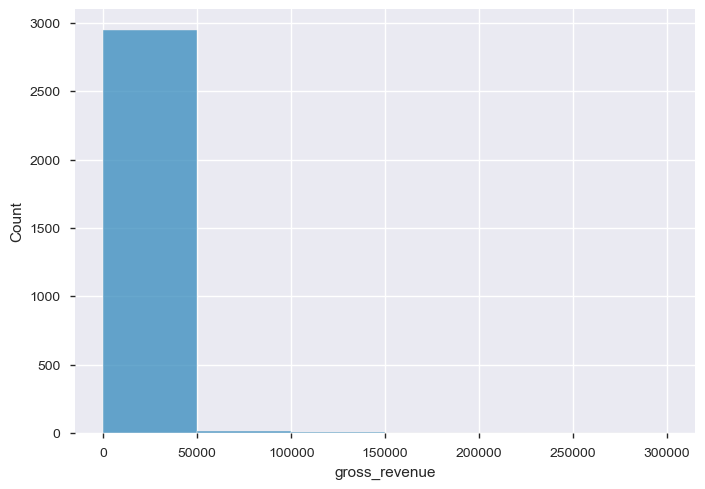

In [135]:
#bin_size = int((df4['gross_revenue'].max() - df4['gross_revenue'].min()) / 5000)

sns.histplot(df4['gross_revenue'], binwidth= 50000) #bins=bin_size)

### 4.1.2 qt_items

In [140]:
df3[df3['customer_id'] == 14646].sort_values('quantity', ascending=False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
416528,573003,23084,2400.0000,2017-10-25,2.0800,Netherlands,14646
404261,572052,22595,1728.0000,2017-10-18,0.7200,Netherlands,14646
62431,541570,21212,1440.0000,2017-01-17,0.4200,Netherlands,14646
529008,581175,23084,1440.0000,2017-12-05,1.7900,Netherlands,14646
184159,552883,21212,1200.0000,2017-05-10,0.4200,Netherlands,14646
...,...,...,...,...,...,...,...
267897,560710,23297,1.0000,2017-07-18,1.6500,Netherlands,14646
267896,560710,22567,1.0000,2017-07-18,1.4500,Netherlands,14646
267903,560710,22758,1.0000,2017-07-18,1.2500,Netherlands,14646
315602,C564899,22956,-144.0000,2017-08-29,1.8500,Netherlands,14646


### 4.1.3 Avg_ticket

In [149]:
df4[df4['avg_ticket']== df4['avg_ticket'].max()]

,customer_id,gross_revenue,recency_days,qt_invoices,qt_items,qt_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
1261,15749,44534.3000,235.0000,3.0000,18028.0000,10.0000,4453.4300,97.0000,0.0309,9014.0000,6009.3333,3.3333


### 4.1.4. Frequency

In [109]:
df4[df4['frequency'] == df4['frequency'].max()]

,customer_id,gross_revenue,recency_days,qt_invoices,qt_items,qt_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,35.5000,34.0000,21.0000,50.9706,8.7353


## 4.2. Bivariate Analysis

In [150]:
df42 = df4.drop('customer_id',axis=1)

<Figure size 2500x1500 with 0 Axes>

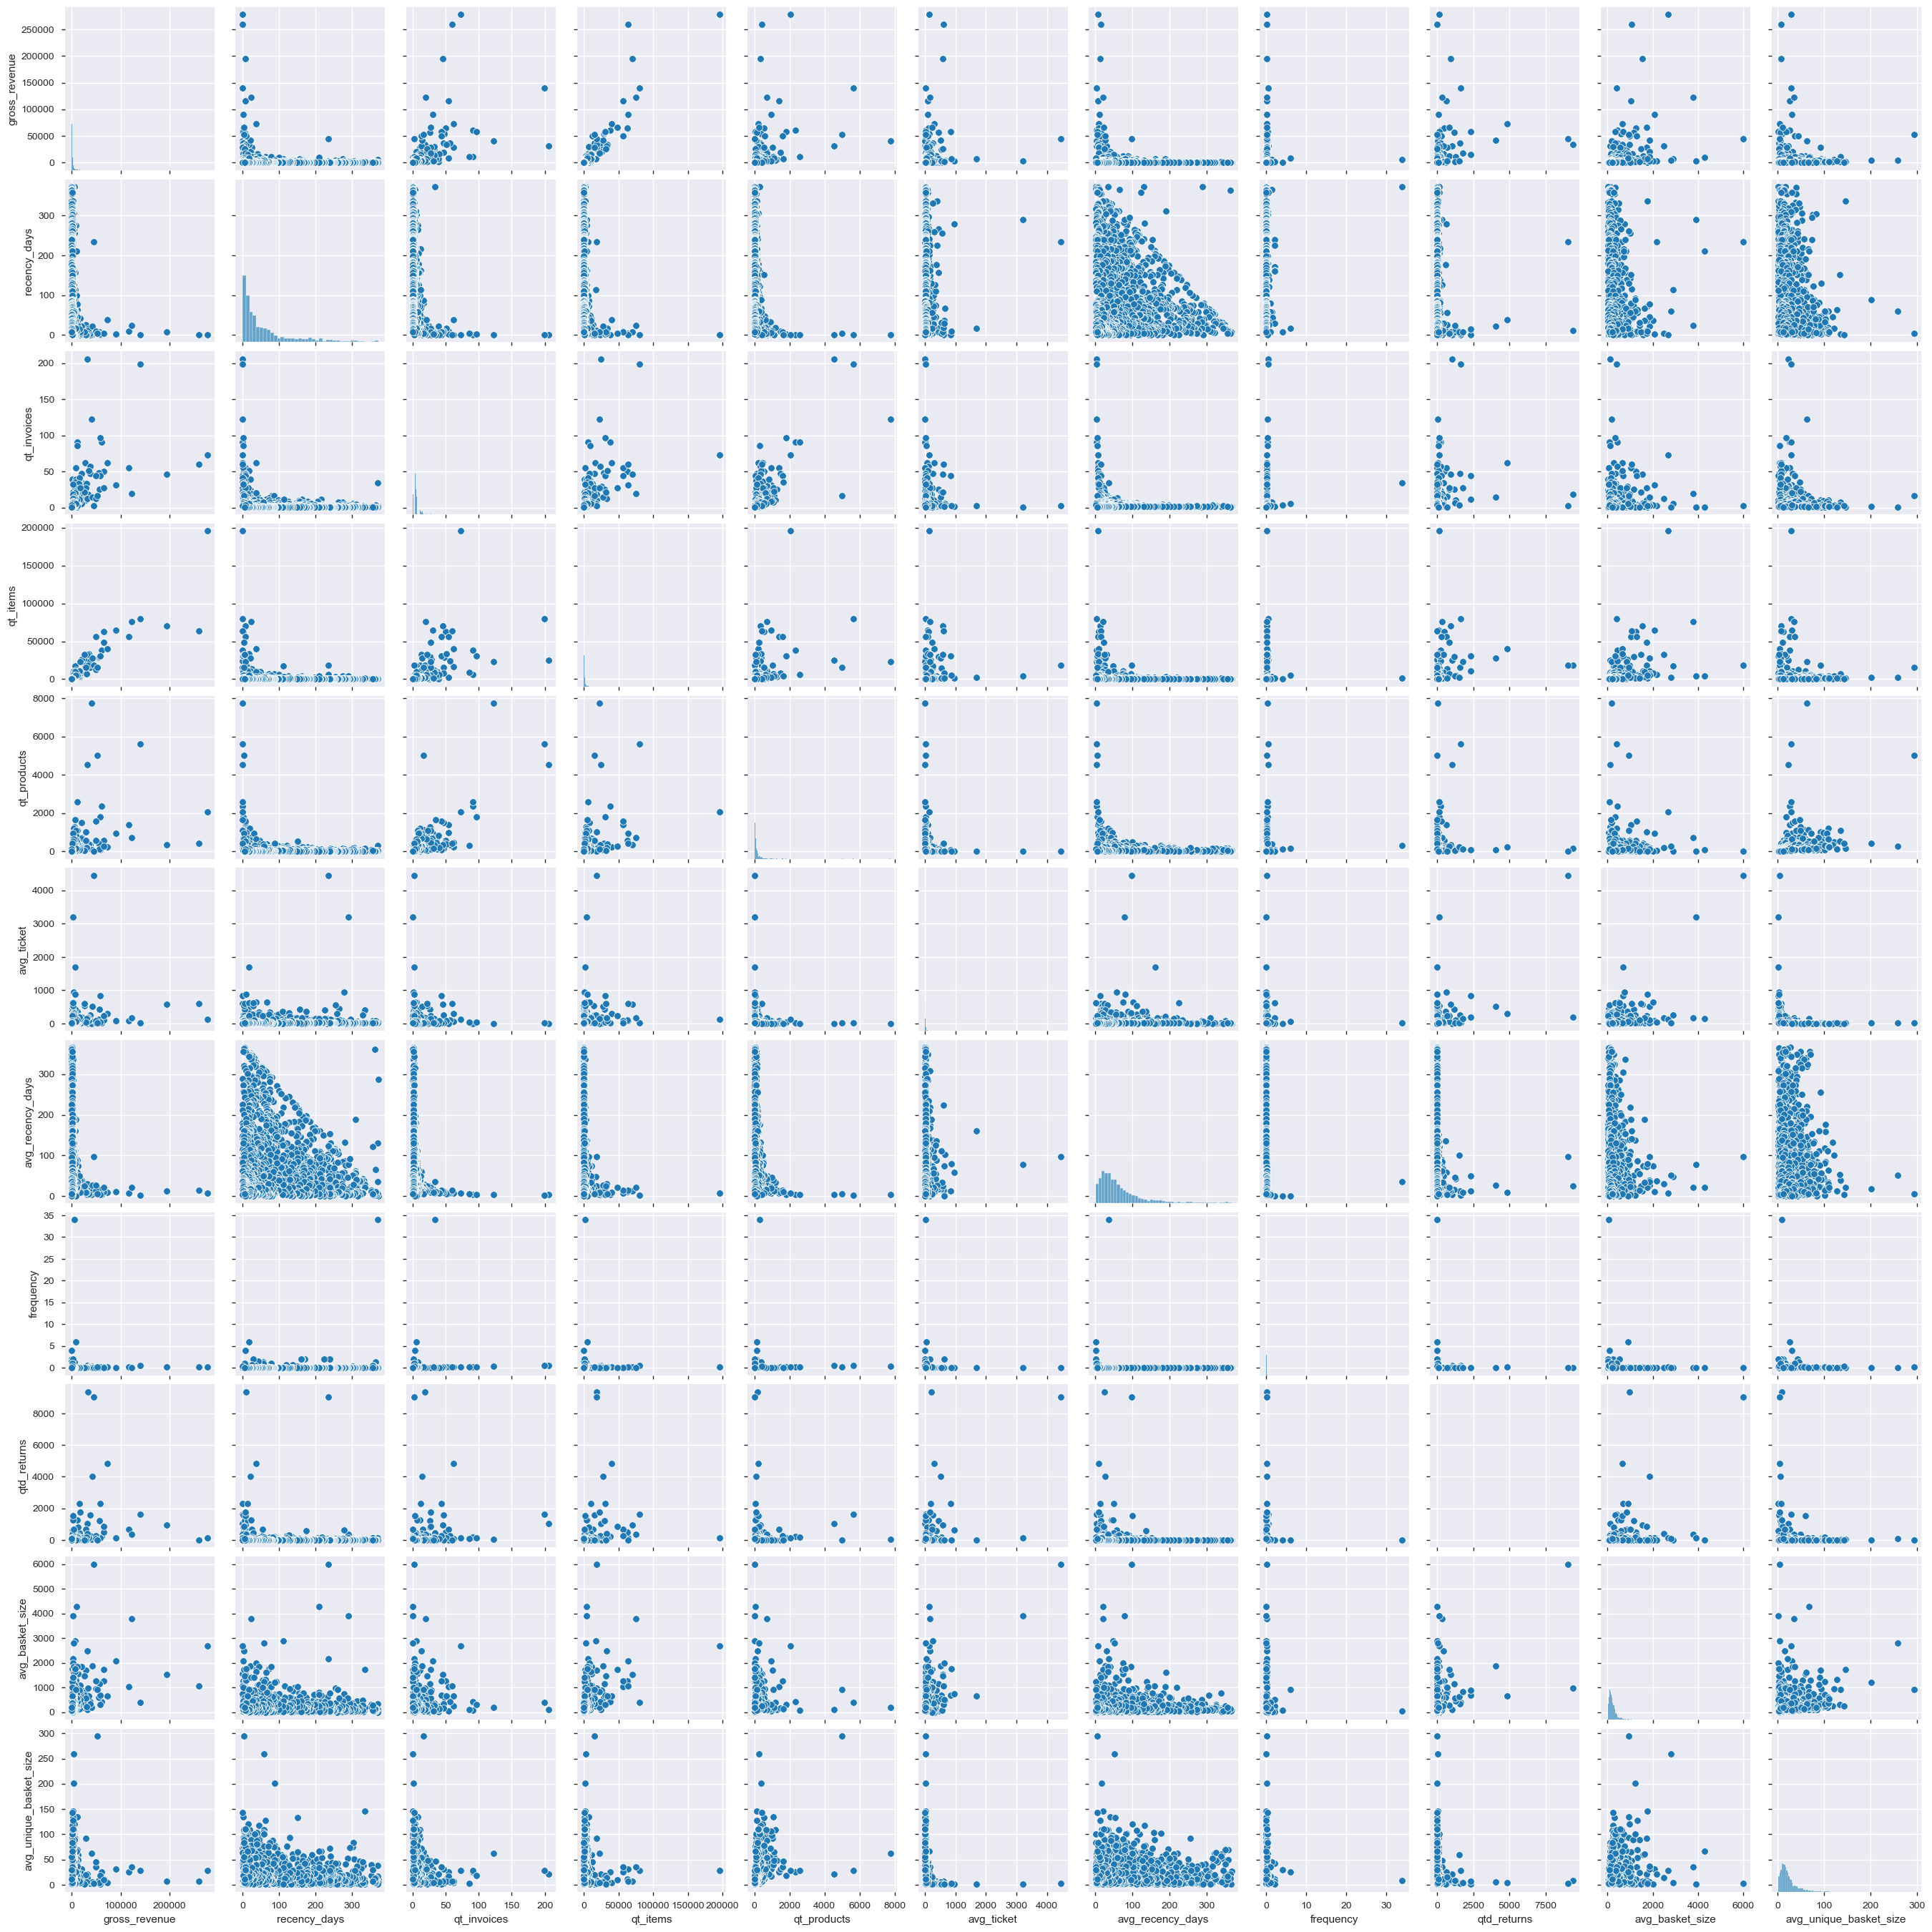

In [151]:
plt.figure(figsize=(25,15))
sns.pairplot(df42)

**Notes**

- Baixa variação da variável Frequency
- Baixa variação da variável Avg Ticket

## 4.3. Estudo do Espaço

In [110]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [111]:
df43.columns

Index(['gross_revenue', 'recency_days', 'qt_invoices', 'qt_items',
       'qt_products', 'avg_ticket', 'avg_recency_days', 'frequency',
       'qtd_returns', 'avg_basket_size', 'avg_unique_basket_size'],
      dtype='object')

In [112]:
## MinMaxScaler

mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['qt_invoices'] = mm.fit_transform(df43[['qt_invoices']])
df43['qt_items'] = mm.fit_transform(df43[['qt_items']])
df43['qt_products'] = mm.fit_transform(df43[['qt_products']])
df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qtd_returns'] = mm.fit_transform(df43[['qtd_returns']])
df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1. PCA

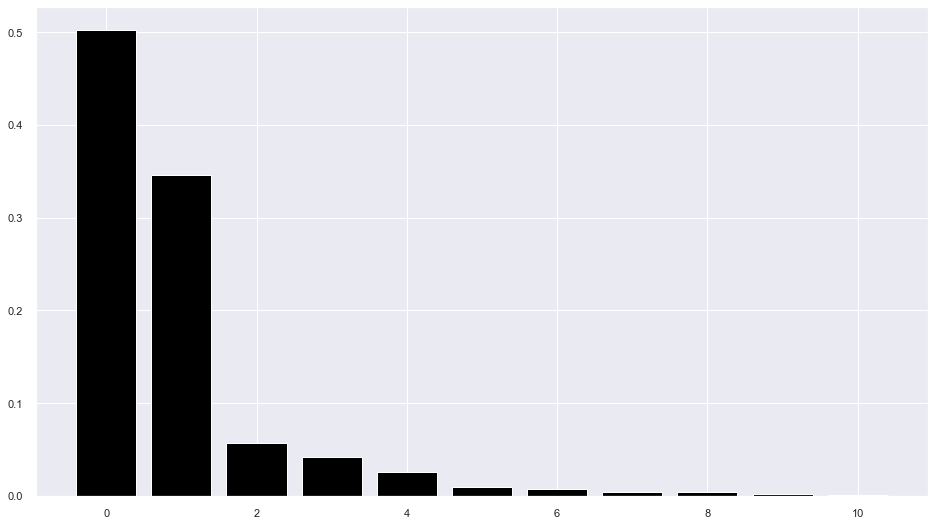

In [113]:
pca = dd.PCA(n_components=X.shape[1] )

principal_components = pca.fit_transform(X)

# plot explained varibles
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black');

# pca component
df_pca = pd.DataFrame(principal_components)

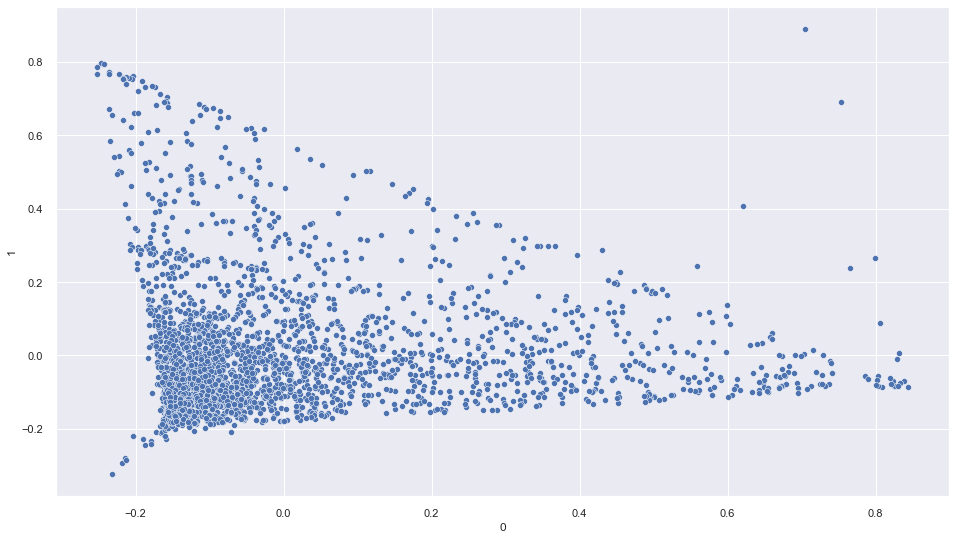

In [114]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2. UMAP

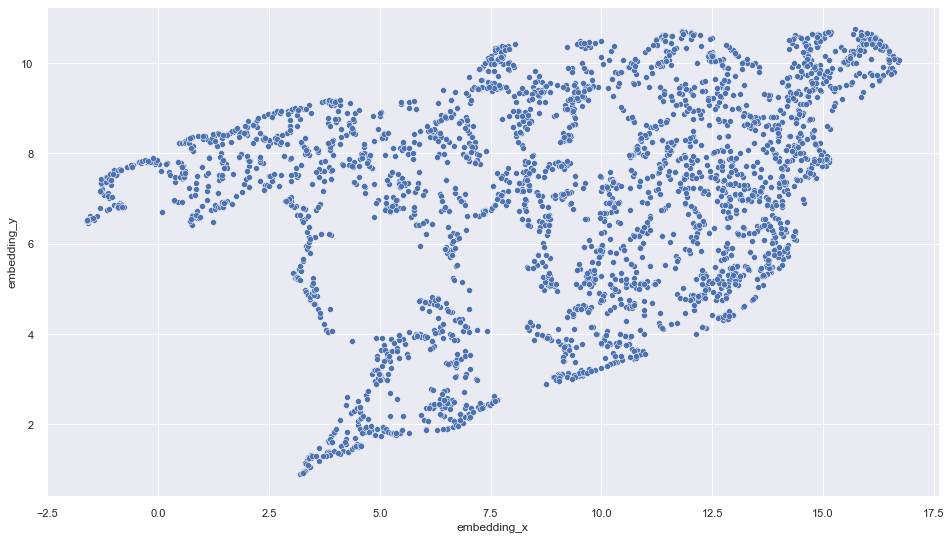

In [115]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### 4.3.3. t-SNE

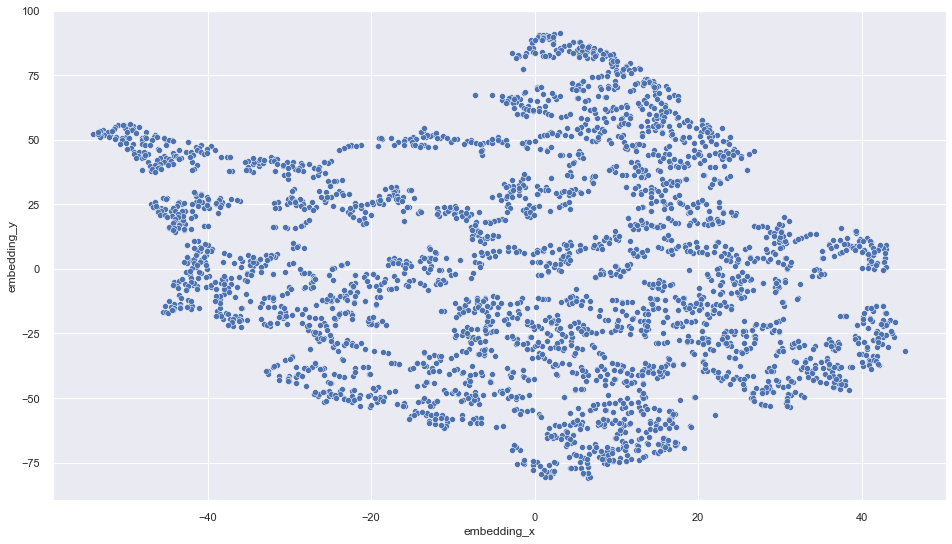

In [116]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### 4.3.4. Tree-Based Embedding

In [117]:
#training dataset
x = df4.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df4['gross_revenue']

In [118]:
#model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

#model training
rf_model.fit(x,y)

#dataframe leafs
df_leaf = pd.DataFrame(rf_model.apply(x))

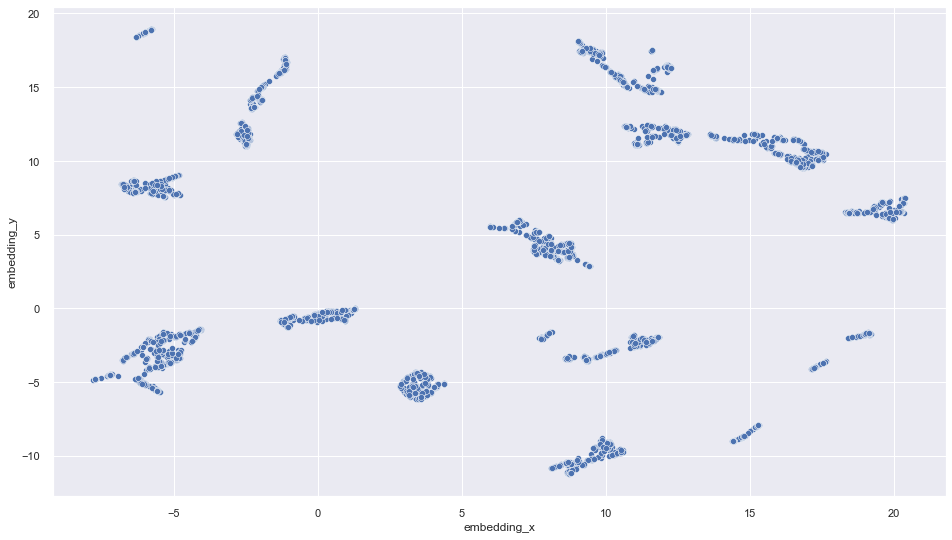

In [119]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

# <font color='red'> 5.0. Data Preparation </font>

In [125]:
df5 = df4.copy()

In [126]:
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qt_invoices',
       'qt_items', 'qt_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtd_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [127]:
## Standard Scaler
mm = pp.MinMaxScaler()

df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
df5['qt_invoices'] = mm.fit_transform(df5[['qt_invoices']])
df5['qt_items'] = mm.fit_transform(df5[['qt_items']])
df5['qt_products'] = mm.fit_transform(df5[['qt_products']])
df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = mm.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = mm.fit_transform(df5[['frequency']])
df5['qtd_returns'] = mm.fit_transform(df5[['qtd_returns']])
df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = mm.fit_transform(df5[['avg_unique_basket_size']])

# <font color='red'> 6.0. Feature Selection </font>

In [129]:
df6 = df5.copy()
df5.head()

,customer_id,gross_revenue,recency_days,qt_invoices,qt_items,qt_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.0194,0.9973,0.1610,0.0089,0.0382,0.0036,0.0945,1.0000,0.0022,0.0083,0.0264
1,13047,0.0113,0.1501,0.0390,0.0064,0.0212,0.0038,0.0719,0.0008,0.0006,0.0229,0.0591
2,12583,0.0241,0.0054,0.0683,0.0257,0.0298,0.0060,0.0608,0.0012,0.0053,0.0556,0.0493
3,13748,0.0034,0.2547,0.0195,0.0022,0.0035,0.0071,0.2511,0.0005,0.0000,0.0144,0.0157
4,15100,0.0031,0.8928,0.0098,0.0004,0.0003,0.0651,0.0208,0.0022,0.0024,0.0043,0.0000


# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [130]:
X = df6.drop(columns=['customer_id'])

In [131]:
X.head(3)

,gross_revenue,recency_days,qt_invoices,qt_items,qt_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,0.0194,0.9973,0.1610,0.0089,0.0382,0.0036,0.0945,1.0000,0.0022,0.0083,0.0264
1,0.0113,0.1501,0.0390,0.0064,0.0212,0.0038,0.0719,0.0008,0.0006,0.0229,0.0591
2,0.0241,0.0054,0.0683,0.0257,0.0298,0.0060,0.0608,0.0012,0.0053,0.0556,0.0493


In [ ]:
clusters = [2, 3, 4, 5, 6, 7]

## <font color='black'> 7.1. Within-Cluster Sum of Square (WSS) </font>

Métrica que verifica as distâncias entre os pontos dos clusters. Verifica a compreesão dos pontos entre clusters.

O cluster adequado, seria o cluster com maior variação entre o resultado dos clusters. Soma da distância entre os pontos de um mesmo clusters, em relação ao centroide, ou seja, quanto menor, melhor é o agrupamento.

O centroide pode ser um valor, ou uma média entre os pontos.

Melhor seleção de cluster, é quando os clusters são condensados e distântes entre si.

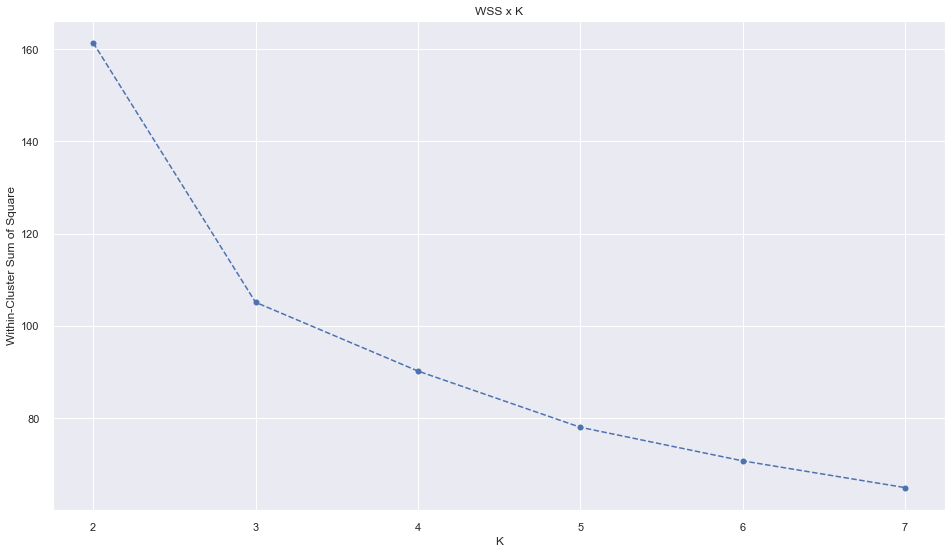

In [133]:
wss = []

for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) # radom = iniciar por centroides aleatórios, n_init = diminuir o vies da seleção, 

    #model training
    kmeans.fit(X)

    #validation
    wss.append(kmeans.inertia_)
    
#plot wss - Elbow methods
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS x K');

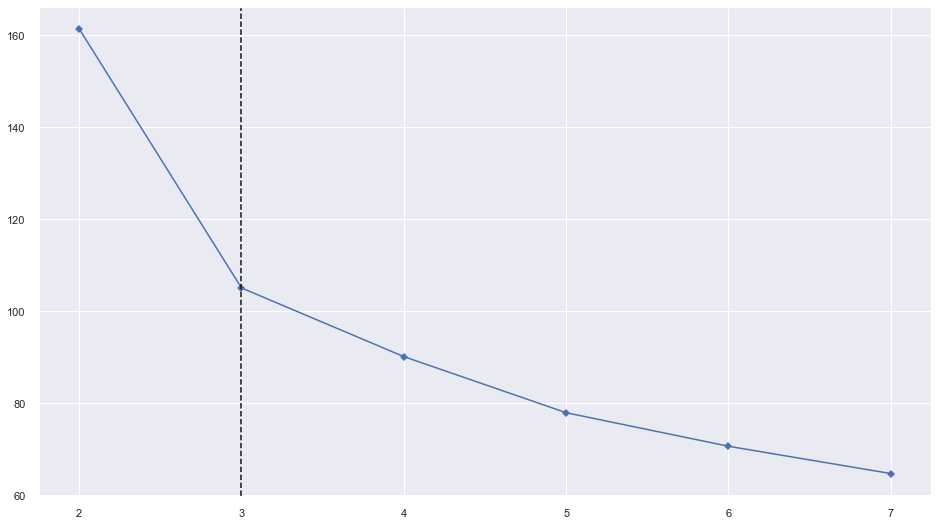

In [134]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False )
kmeans.fit(X);

In [135]:
wss

[161.40822582394372,
 105.09694629493816,
 90.18034104464773,
 77.98438116522105,
 70.68915680642795,
 64.89122278329147]

## <font color='black'> 7.2. Silhouette Score </font>

Silhouette Score - Verifica a distância dos clusters

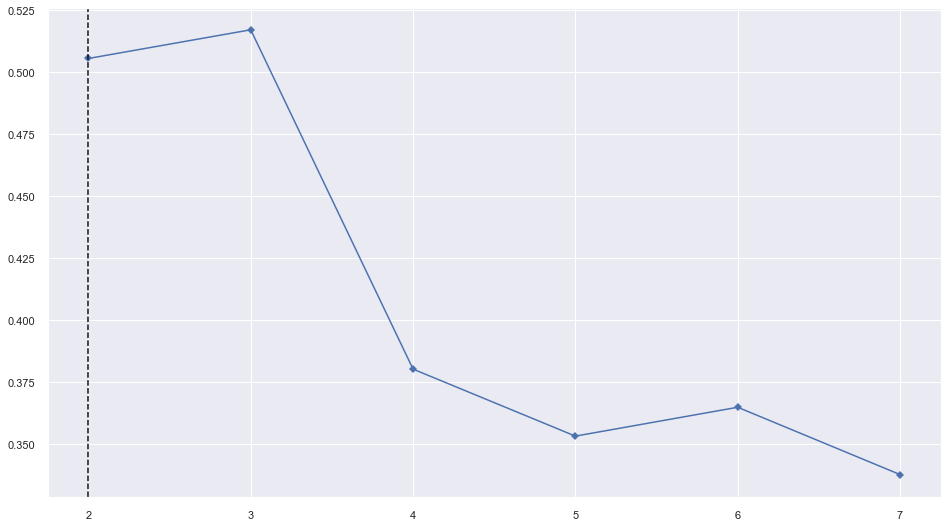

In [136]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X);

## 7.1. Silhouette Analysis

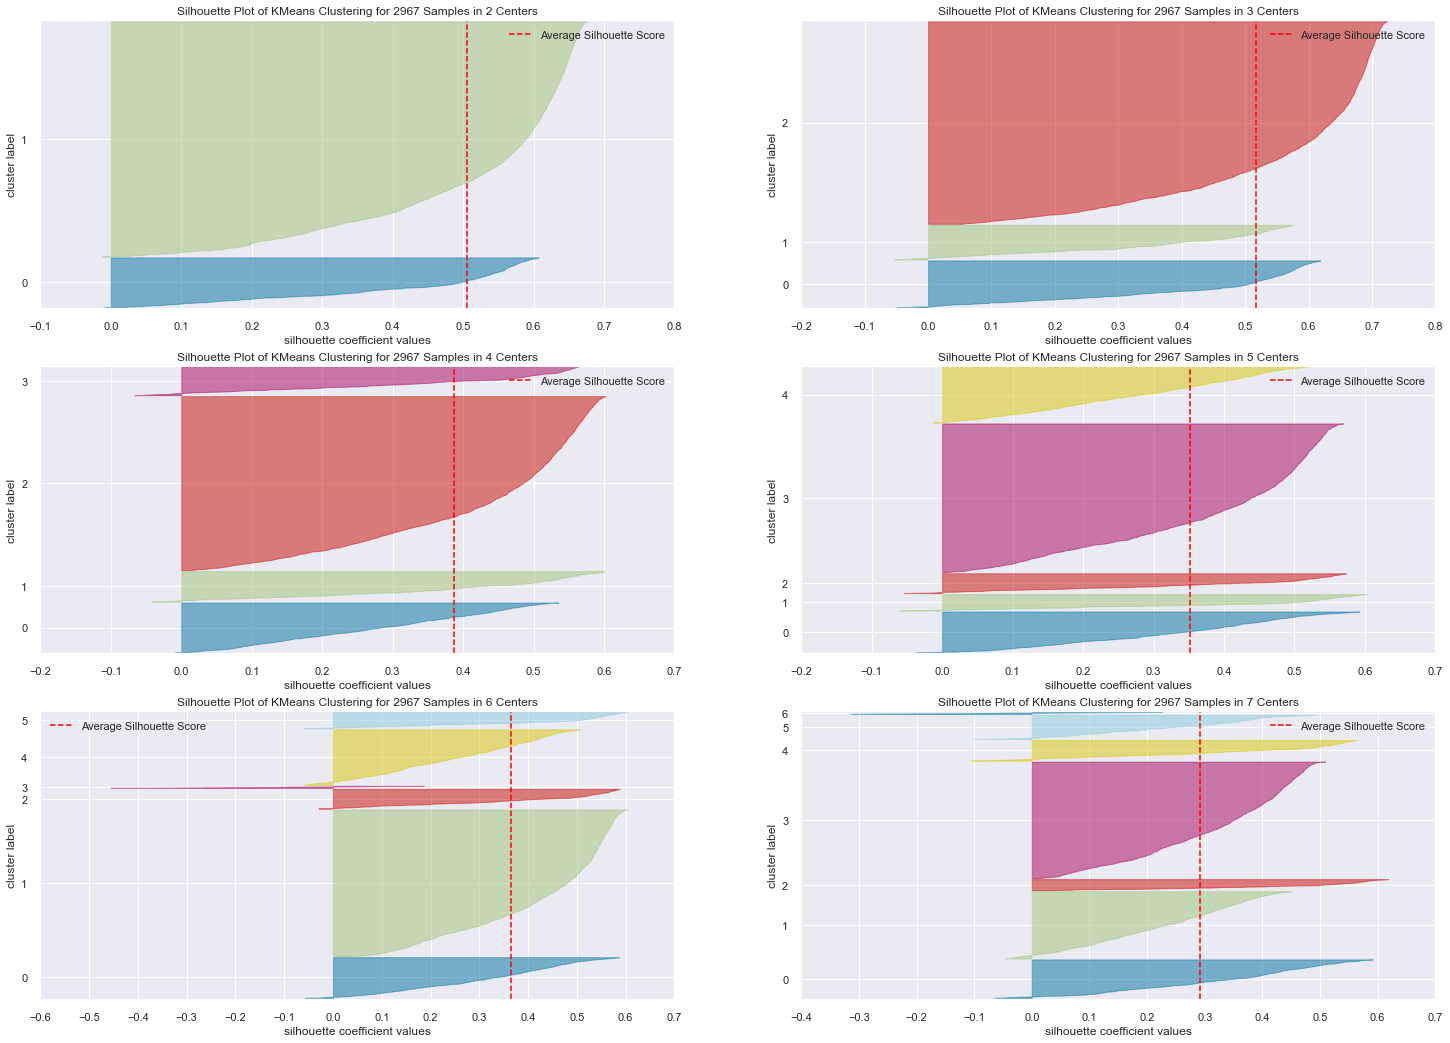

In [137]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [262]:
#model definition
k=3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2. Cluster Validation

In [263]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# SS
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 9585.837579326426
SS value: 0.5906530607172846


# <font color='red'> 9.0. Cluster Analysis </font>

In [264]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.40,2.79,3.89,-0.03,0.00,1
1,13047,0.14,-0.36,0.62,-0.03,0.00,0
2,12583,0.55,-0.90,1.41,-0.02,0.00,0
3,13748,-0.12,0.03,0.10,-0.02,0.00,0
4,15100,-0.13,2.40,-0.16,0.20,0.00,1


## <font color='black'> 9.1. Visualization Inspection </font>

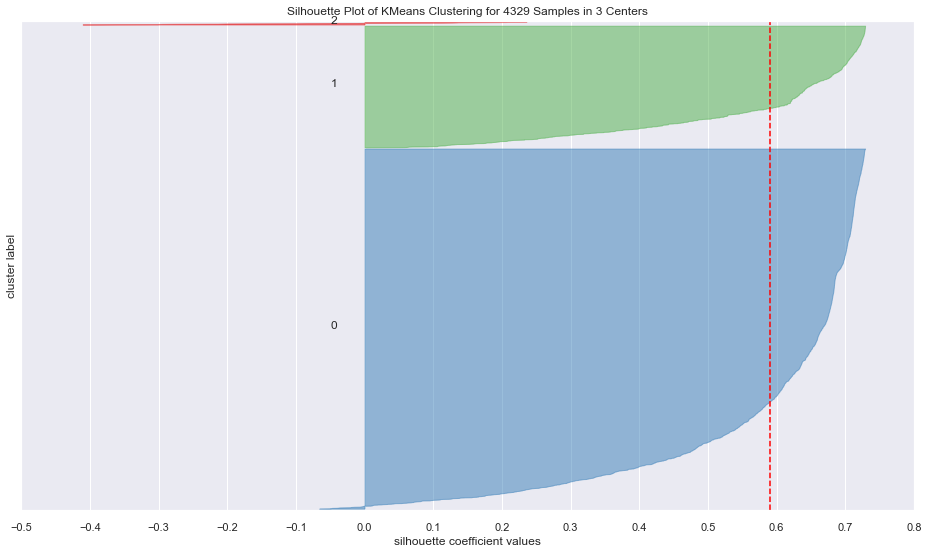

In [265]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.2. 2D Plot

In [269]:
#df_viz = df9.drop(columns='customer_id', axis=1)
#sns.pairplot(df_viz, hue='cluster');

## 9.3. UMAP

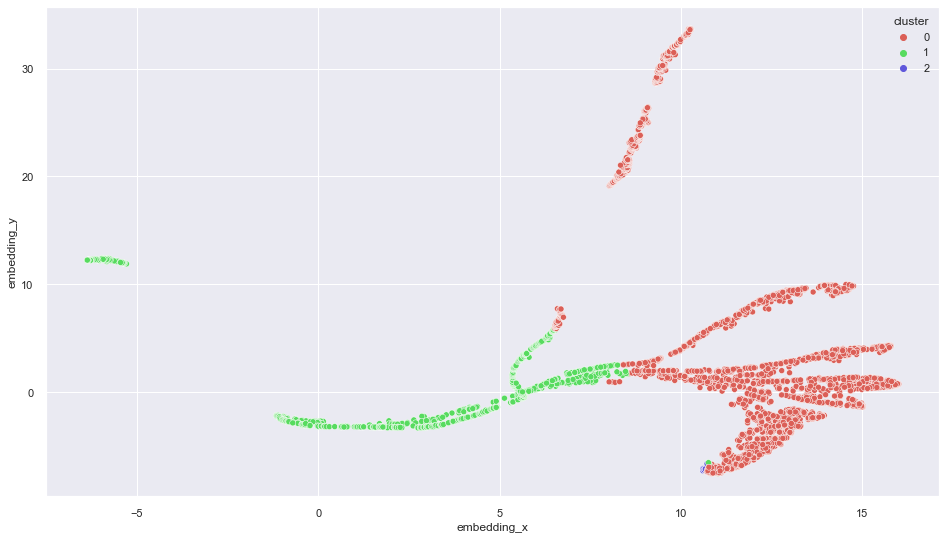

In [272]:
reducer = umap.UMAP(n_neighbors=90,random_state=42)
embedding = reducer.fit_transform(X) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

In [273]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2. Cluster Profile

In [274]:
#Number of customer
df9_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df9_cluster['percentage'] = 100*(df9_cluster['customer_id'] / df9_cluster['customer_id'].sum())

#Avg Gross Revenue
df_avg_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_revenue, how='inner', on='cluster')

#Avg Recency Days
df_avg_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_days, how='inner', on='cluster')

#Avg Frequency
df_avg_freq = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_freq, how='inner', on='cluster')

#Avg Frequency
df_avg_tkt = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_tkt, how='inner', on='cluster')

In [275]:
df9_cluster

,cluster,customer_id,percentage,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3217,74.31,-0.02,-0.51,0.05,-0.02
1,1,1087,25.11,-0.17,1.54,-0.35,0.00
2,2,25,0.58,9.40,-0.74,8.33,2.68


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $181.395,49 dólares
        
### Cluster 02: 
    - Número de customers: 29 (0.66 do customers )
    - Recência em média: 14 dias
    - Compras em média: 55 compras
    - Receita em média: $41.563,71 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 4 compras
    - Receita em média: $1.373,34 dólares

# <font color='red'> 10.0. Deploy To Production </font>